# Variational Autoencoder Demonstration
The purpose of this notebook is to demonstrate a simple Variational Autoencoder (VAE) model, trained on SELF-referencIng Embedded Strings (SELFIES).

## Load and prepare the data

Call `bddata.setup` to:
 - Download the QM9 dataset to a location outside of source code control. 
 - Compute the SELFIES from SMILES, discarding records with unusable SMILES strings
 - Calculate QM9 dataset summary statistics
 - Create the vocabulary
 - Pad SELFIES out to the length of the record with the maximal SELFIES tokens
 - Add a start token to facilitate transition probability profile generation

In [2]:
%%time
from importlib import reload

import bd
reload(bd)
from bd import data as bddata
from bd import log as bdl

PAD_TOKEN="<pad>"
START_TOKEN="<start>"


bdl.set_verbosity(bdl.INFO)
dataset_selfies, max_tokens, token_stats, vocab, start_token, pad_token = bddata.setup(data_path='../../data/QM9',
                                                                           start_token=START_TOKEN,
                                                                           pad_token=PAD_TOKEN)


+ Add SELFIES to the dataset entries...
outputting 'x' for each record skipped due to unusable SMILES string.
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [3]:
len(dataset_selfies), max_tokens, token_stats, len(vocab),  start_token, pad_token 

(129428,
 21,
 {'median': 13.0,
  'average': 13.759194301078592,
  'std': 2.0650592942840698,
  'max': 21,
  'min': 1},
 56,
 '<start>',
 '<pad>')

## Fit the model

Load the data batches, build the model, fit, and plot the train/validation losses.


In [8]:
%%time
import pytorch_lightning as pl
from pytorch_lightning import Trainer


import bd
reload(bd)
from bd.models import VAE
from bd.data import SELFIESDataModule, CustomRichProgressBar


EPOCHS = 6
# Model parameters
vocab_size = len(vocab)  # Make sure vocab includes PAD_TOKEN
BATCH_SIZE= 256 #8* vocab_size
EMBEDDING_DIM = max_tokens#21#32
HIDDEN_DIM = 128#64
LATENT_DIM = 64#16
BETA=1.0
USE_MSE=False

# get the data
data_module = SELFIESDataModule(dataset_selfies, 
                                max_selfies_tokens= max_tokens, 
                                start_token_index=vocab[start_token],
                                train_batch_size=BATCH_SIZE,
                                val_batch_size = BATCH_SIZE,
                                drop_last=True,
                                train_val_split=0.8)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

model = VAE(vocab_size)

# Setup the trainer
trainer = pl.Trainer(max_epochs=EPOCHS)#, callbacks=[CustomRichProgressBar()])  # Adjust according to your setup

# Start training
trainer.fit(model, train_loader, val_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-04-28 19:33:59.624913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 19:33:59.735844: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see

Sanity Checking: |                                                                                            …

/home/krobasky/miniconda3/envs/jupyter/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/krobasky/miniconda3/envs/jupyter/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=6` reached.


CPU times: user 23.9 s, sys: 3.19 s, total: 27.1 s
Wall time: 27.3 s


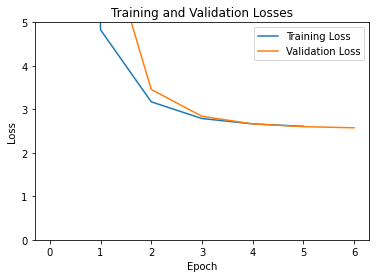

In [9]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(model.train_losses, label='Training Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.show()


## Generate a SELFIES

Use the model to generate of a SELFIES string and view the molecular structure.

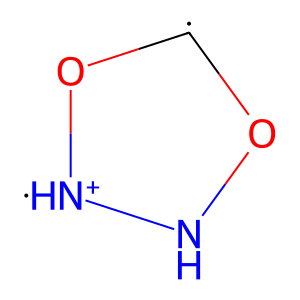

In [11]:
bdl.set_verbosity(bdl.WARN)
gen_max_tokens=35
from bd.assess import generate_and_decode, selfies_to_image
selfies_string, z, generated_indices1 = generate_and_decode(model=model, vocab=vocab, max_tokens=gen_max_tokens, 
                                                                start_token=start_token, 
                                                                pad_token=pad_token, 
                                                                z=None)
display(selfies_to_image(selfies_string))